In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import warnings
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

warnings.filterwarnings('ignore')
df = pd.read_csv("MakroDashboard\data\ML data\Monthly_wide_diff.csv")  # Make sure it has 15 columns
#df = pd.read_csv("MakroDashboard\data\ML data\Quarterly_wide_diff.csv") 

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Ricks\AppData\Local\Temp\ipykernel_11596\95768167.py:21: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv("MakroDashboard\data\ML data\Monthly_wide_diff.csv")  # Make sure it has 15 columns


## Processing the data

In [2]:
# Step 1: Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by='time')

# Step 2: Select numeric columns
df_numeric = df.select_dtypes(include=["number"])

# Step 3: Add time column back
df_final = pd.concat([df_numeric, df[['time']]], axis=1)

# Step 4: Fill NaNs
df_final = df_final.dropna()

# Step 5: Identify target columns (Finland columns)
finland_columns = [col for col in df_final.columns if 'Finland' in col]

In [ ]:
#df_new_test = df[finland_columns]
#df_new_test = pd.concat([df_numeric, df[['time']]], axis=1)
#df_final = df_new_test

#df_new_test2 = df_numeric[finland_columns]
#df_numeric = df_new_test2

In [ ]:
# Step 6: Create lagged features for all numeric columns (excluding 'time')
#def create_lag_features(df, columns, lags=10):
#    for col in columns:
#        for lag in range(1, lags + 1):
#            df[f'{col}_lag{lag}'] = df[col].shift(lag)
#    return df

# Create lag features
#lagged_df = create_lag_features(df_final.copy(), df_numeric.columns, lags=10)
#lagged_df

,Infaltion CPI_Denmark,Infaltion CPI_Germany,Infaltion CPI_Spain,Infaltion CPI_France,Infaltion CPI_Italy,Infaltion CPI_Netherlands,Infaltion CPI_Finland,Infaltion CPI_Sweden,Change in energy price_Denmark,Change in energy price_Germany,...,Change in food price_Sweden,Unemployment data_Denmark,Unemployment data_Germany,Unemployment data_Spain,Unemployment data_France,Unemployment data_Italy,Unemployment data_Netherlands,Unemployment data_Finland,Unemployment data_Sweden,time
1,2.1,1.6,2.5,1.7,2.4,1.4,0.6,1.1,5.5,4.3,...,0.3,-0.1,0.0,-0.1,0.0,0.1,-0.1,-0.1,0.4,1997-02-01
2,1.8,1.3,2.2,1.1,2.2,1.2,0.7,1.0,3.6,3.5,...,-1.7,-0.2,0.1,-0.1,0.0,0.0,-0.1,-0.1,0.0,1997-03-01
3,1.7,1.2,1.6,1.0,1.9,1.0,0.9,1.2,0.9,2.1,...,-1.0,-0.1,0.1,0.0,0.1,0.1,-0.1,-0.1,-0.2,1997-04-01
4,2.1,1.5,1.3,0.9,1.9,1.6,0.9,1.2,2.1,2.3,...,-0.3,0.1,0.0,0.1,-0.1,0.0,-0.1,-0.2,0.0,1997-05-01
5,2.4,1.5,1.4,1.0,1.6,1.5,1.1,1.6,2.9,3.0,...,0.3,-0.1,0.0,0.1,0.0,0.0,-0.1,-0.3,0.3,1997-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,1.6,2.4,1.8,1.6,1.0,3.3,1.5,1.6,3.1,-5.4,...,1.6,-0.7,-0.1,-0.2,0.0,-0.2,0.0,0.3,-0.3,2024-10-01
334,1.6,2.4,2.4,1.7,1.5,3.8,1.7,2.0,5.4,-3.6,...,1.5,0.9,0.0,-0.2,-0.1,0.0,0.0,0.0,0.0,2024-11-01
335,1.8,2.8,2.8,1.8,1.4,3.9,1.6,1.6,5.7,-1.5,...,1.1,0.2,0.1,-0.1,0.0,0.3,0.0,-0.2,0.2,2024-12-01
336,1.4,2.8,2.9,1.8,1.7,3.0,1.7,2.0,2.0,-1.3,...,1.6,-0.3,0.0,-0.1,0.0,-0.1,0.1,0.3,1.1,2025-01-01


In [4]:
# Step 6: Create lagged features for all numeric columns (excluding 'time')
def create_lag_features(df, columns, lags=4):
    for col in columns:
        for lag in range(1, lags + 1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

# Create lag features
lagged_df = create_lag_features(df_final.copy(), df_numeric.columns, lags=4)

# Step 7: Create future target (1 step ahead)
horizon = 3  # You can change this to 3 for 3-month ahead prediction
for col in finland_columns:
    lagged_df[f'{col}_target'] = lagged_df[col].shift(-horizon)

# Step 8: Drop original (non-lagged) features + rows with NaN
lagged_df = lagged_df.drop(columns=finland_columns + ['time'])  # keep only lags + targets
#lagged_df = lagged_df.dropna()

# Impute missing values with the mean for each column
lagged_df = lagged_df.fillna(lagged_df.mean())

# Step 9: Train/test split
train_size = int(len(lagged_df) * 0.8)
train_data = lagged_df.iloc[:train_size]
test_data = lagged_df.iloc[train_size:]

# Step 10: Features (X) and Targets (y)
target_columns = [col for col in lagged_df.columns if col.endswith('_target')]

X_train = train_data.drop(columns=target_columns)
y_train = train_data[target_columns]

X_test = test_data.drop(columns=target_columns)
y_test = test_data[target_columns]



## The modeling

In [5]:
# Select a model 
selected_model = 'xgb'  # 'rf' or 'xgb'

# Define base model and param grid
if selected_model == 'xgb':
    base_model_class = XGBRegressor
    param_grid = {
        'model__n_estimators': [50, 100, 200, 250],
        'model__max_depth': [1.5, 2, 3, 4],
        'model__learning_rate': [ 0.01, 0.05, 0.1, 0.15]
    }
elif selected_model == 'rf':
    base_model_class = RandomForestRegressor
    param_grid = {
        'model__n_estimators': [50, 100, 200, 250]
    }
elif selected_model == 'Lasso':
    base_model_class = Lasso
    param_grid = {
        'model__alpha': [0.001, 0.01, 0.1, 0.5, 1.0]
    }
elif selected_model == 'Ridge':
    base_model_class = Ridge
    param_grid = {
        'model__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2, 2,5, 3, 4]
    }
else:
    raise ValueError("Choose either 'xgb', 'rf', 'Lasso' or 'Ridge'.")


# === LOOP OVER TARGETS ===
all_best_models = []
all_results = []

for i, target in enumerate(y_train.columns):
    print(f" Tuning model for target: {target}")

    y_target = y_train[target]
    y_target_test = y_test[target]

    model = base_model_class()
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])

    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=6)
    grid.fit(X_train, y_target)

    best_model = grid.best_estimator_
    all_best_models.append(best_model)

    # Predict on test set and calculate R²
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_target_test, y_pred)

    all_results.append({
        'target': target,
        'best_params': grid.best_params_,
        'best_mse': -grid.best_score_,
        'r2_score': r2
    })

# Create MultiOutputRegressor from the tuned models
multi_model = MultiOutputRegressor(estimator=None)
multi_model.estimators_ = all_best_models

# Store results as DataFrame
results_df = pd.DataFrame(all_results)

# Print the full results with expanded columns
print("\n📊 Full tuning results per target:\n")
pd.set_option('display.max_colwidth', None)  # Show full parameter dict
print(results_df.to_string(index=False))


 Tuning model for target: Infaltion CPI_Finland_target
 Tuning model for target: Change in energy price_Finland_target
 Tuning model for target: Change in food price_Finland_target
 Tuning model for target: Unemployment data_Finland_target

📊 Full tuning results per target:

                               target                                                                       best_params  best_mse  r2_score
         Infaltion CPI_Finland_target {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 200}  0.431564  0.378546
Change in energy price_Finland_target {'model__learning_rate': 0.01, 'model__max_depth': 2, 'model__n_estimators': 200} 32.597903  0.041773
  Change in food price_Finland_target   {'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__n_estimators': 50}  3.956592  0.685844
     Unemployment data_Finland_target {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 200} 25.126366 -0.328532


## Predictions 

In [6]:
n_steps = 3  # number of months ahead to forecast
future_forecasts = []

# Start with the most recent input
current_input = X_test.iloc[[-1]].copy()

# Get the feature names from X_train
feature_names = X_train.columns

# Loop through the steps to forecast
for step in range(n_steps):
    # Ensure the current_input contains the correct features
    current_input = current_input[feature_names]
    
    # Predict the next step
    prediction = multi_model.predict(current_input)[0]
    future_forecasts.append(prediction)

    # Shift lag features forward (lag3 -> lag2, lag2 -> lag1, lag1 -> prediction)
    new_input = current_input.copy()
    for i, col in enumerate(y_test.columns):
        try:
            # Shift lags: lag3 -> lag2, lag2 -> lag1
            for lag in range(3, 1, -1):
                new_input[f'{col}_lag{lag}'] = new_input.get(f'{col}_lag{lag-1}', np.nan)
            # Set lag1 to the current prediction for the variable
            new_input[f'{col}_lag1'] = prediction[i]
        except KeyError as e:
            print(f"Skipping column due to KeyError: {e}")

    # Update the input for the next step (if forecasting more than 1 step ahead)
    current_input = new_input.copy()

# Convert forecast list to DataFrame
future_forecast_df = pd.DataFrame(future_forecasts, columns=y_test.columns)

# Print the forecasted values for the next n_steps
print("Forecasts for the next", n_steps, "months:")
print(future_forecast_df)


Forecasts for the next 3 months:
   Infaltion CPI_Finland_target  Change in energy price_Finland_target  \
0                      1.294176                               1.502403   
1                      1.294176                               1.502403   
2                      1.294176                               1.502403   

   Change in food price_Finland_target  Unemployment data_Finland_target  
0                              0.93526                         -0.941727  
1                              0.93526                         -0.941727  
2                              0.93526                         -0.941727  


In [10]:

n_steps = 3  # number of months ahead to forecast
future_forecasts = []

# Start with the most recent input
current_input = X_test.iloc[[-1]].copy()

# Get the feature names from X_train
feature_names = X_train.columns

for step in range(n_steps):
    # Ensure the current_input contains the correct features
    current_input = current_input[feature_names]

    # Predict the next step
    prediction = multi_model.predict(current_input)[0]
    future_forecasts.append(prediction)

    # Shift lag features forward (lag3 -> lag2, lag2 -> lag1)
    new_input = current_input.copy()
    for i, target_col in enumerate(y_test.columns):
        for lag in range(3, 1, -1):
            try:
                new_input[f'{target_col}_lag{lag}'] = new_input[f'{target_col}_lag{lag-1}']
            except KeyError:
                new_input[f'{target_col}_lag{lag}'] = np.nan
        # Set lag1 to the current prediction for the variable
        new_input[f'{target_col}_lag1'] = prediction[i]

    # Update current_input for the next forecast step
    current_input = new_input.copy()


# Print the forecasted values for the next n_steps
print(f"\n📈 Forecasts for the next {n_steps} months:")
print(future_forecast_df.to_string(index=False))


📈 Forecasts for the next 3 months:
 Infaltion CPI_Finland_target  Change in energy price_Finland_target  Change in food price_Finland_target  Unemployment data_Finland_target
                     1.294176                               1.502403                              0.93526                         -0.941727
                     1.294176                               1.502403                              0.93526                         -0.941727
                     1.294176                               1.502403                              0.93526                         -0.941727


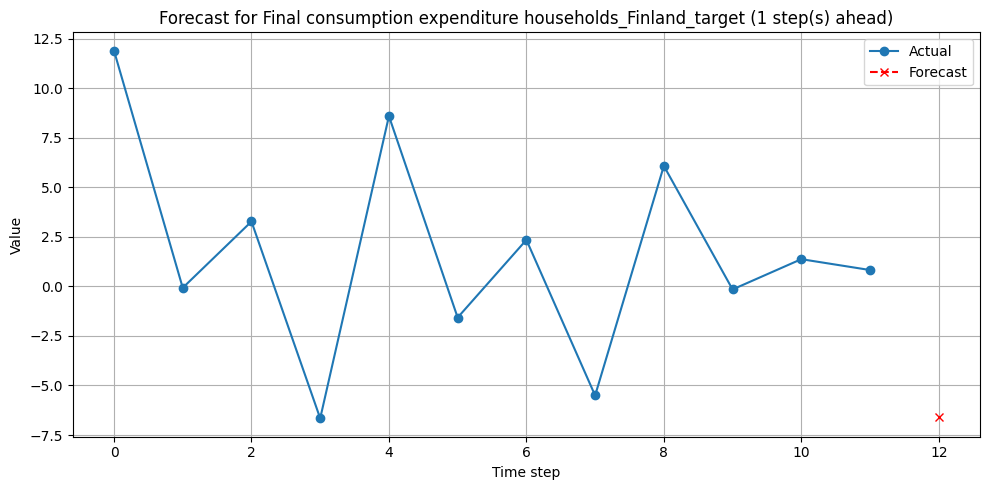

In [9]:
# Choose one variable to plot, e.g., the first one
target_column = y_test.columns[4]

# Combine last few actual values with the forecast
recent_actuals = y_test[target_column].tail(12).reset_index(drop=True)
forecast_values = pd.Series(future_forecast_df[target_column].values, index=range(len(recent_actuals), len(recent_actuals) + n_steps))

plt.figure(figsize=(10, 5))
plt.plot(recent_actuals, label="Actual", marker='o')
plt.plot(forecast_values, label="Forecast", marker='x', linestyle='--', color='red')
plt.title(f"Forecast for {target_column} ({n_steps} step(s) ahead)")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# Define the last known date
last_date = pd.to_datetime(df["time"]).max()

# Number of forecast steps
n_steps = len(future_forecast_df)

# Create future monthly dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_steps, freq='MS')

# Assign the future dates as the index of the forecast DataFrame
future_forecast_df.index = future_dates


# Save to CSV 
#future_forecast_df.to_csv("MakroDashboard\\data\\ML_predictions\\forecasted_features_with_dates_montlhy.csv", index_label="Date")
future_forecast_df.to_csv("MakroDashboard\\data\\ML_predictions\\forecasted_features_with_dates_Q.csv", index_label="Date")

## Feature importnace

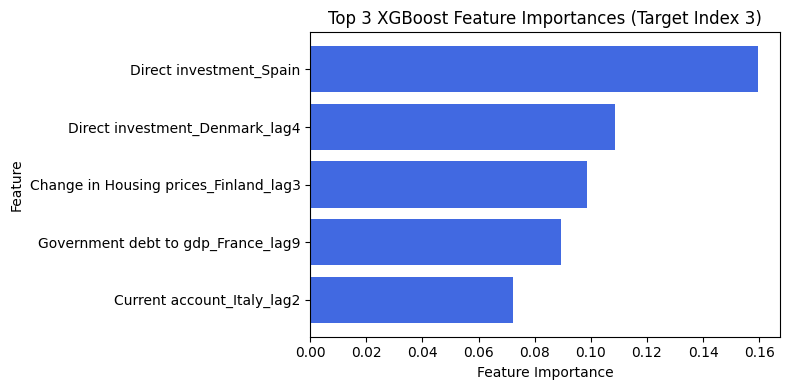

In [11]:
importance = all_best_models[5].named_steps['model'].feature_importances_

## Convert to DataFrame
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importance
})

# Sort and keep top 3 features
top_features = feature_importance.sort_values(by="Importance", ascending=False).head(5)

# Plot top 3 feature importances
plt.figure(figsize=(8, 4))
plt.barh(top_features["Feature"], top_features["Importance"], color='royalblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 3 XGBoost Feature Importances (Target Index 3)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
# Define the model names in the same order as the models in all_best_models
model_names = [
    "Current account", "Direct investment", "Employees Compensation", 
    "Total employment", "Final consumption expenditure households", 
    "Change in GDP", "Gross fixed capital formation", "Government debt to GDP", 
    "Government expenditure", "Change in Housing prices", "Labour productivity", 
    "Net international investment", "Nominal unit labour cost"
]

# Initialize an empty list to store the feature importances from all models
all_feature_importances = []

# Loop through each model in all_best_models
for i, model in enumerate(all_best_models):
    # Use the model name from the list, corresponding to the model index
    model_name = model_names[i]
    
    # Extract feature importances from the model
    importance = model.named_steps['model'].feature_importances_
    
    # Create a DataFrame for the current model
    feature_importance = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": importance,
        "Model": model_name,  # Use the model name from the list
        "Model_Index": i  # Add model index (0, 1, 2, etc.)
    })
    
    # Sort by importance and keep top 5 features
    top_features = feature_importance.sort_values(by="Importance", ascending=False).head(5)
    
    # Append the top 5 features of the current model to the list
    all_feature_importances.append(top_features)

# Concatenate all feature importances into one DataFrame
all_feature_importances_df = pd.concat(all_feature_importances, ignore_index=True)

# Save the DataFrame to a CSV file
all_feature_importances_df.to_csv('MakroDashboard\\data\\ML feature importance\\top_5_feature_importances_with_model_names_quaterly.csv', index=False)




In [9]:
## Montlhy
# Define the model names in the same order as the models in all_best_models
model_names = [
    "Infaltion CPI", "Change in energy price", "Change in food price", 
    "Unemployment"
]

# Initialize an empty list to store the feature importances from all models
all_feature_importances = []

# Loop through each model in all_best_models
for i, model in enumerate(all_best_models):
    # Use the model name from the list, corresponding to the model index
    model_name = model_names[i]
    
    # Extract feature importances from the model
    importance = model.named_steps['model'].feature_importances_
    
    # Create a DataFrame for the current model
    feature_importance = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": importance,
        "Model": model_name,  # Use the model name from the list
        "Model_Index": i  # Add model index (0, 1, 2, etc.)
    })
    
    # Sort by importance and keep top 5 features
    top_features = feature_importance.sort_values(by="Importance", ascending=False).head(5)
    
    # Append the top 5 features of the current model to the list
    all_feature_importances.append(top_features)

# Concatenate all feature importances into one DataFrame
all_feature_importances_df = pd.concat(all_feature_importances, ignore_index=True)

# Save the DataFrame to a CSV file
all_feature_importances_df.to_csv('MakroDashboard\\data\\ML feature importance\\top_5_feature_importances_with_model_names_monthly.csv', index=False)



## TEST

In [ ]:
future_forecast_df

,Current account_Finland_target,Direct investment_Finland_target,Employees Compensation_Finland_target,Totlat employment_Finland_target,Final consumption expenditure households_Finland_target,Change in GDP_Finland_target,Gross fixed capital formation_Finland_target,Government debt to gdp_Finland_target,Government expenditure_Finland_target,Change in Housing prices_Finland_target,Labour productivity_Finland_target,Net international investment_Finland_target,Nominal unit labour cost_Finland_target
0,0.048359,165459.28125,27684.603516,2652.031982,30990.894531,1.329585,15172.918945,72.277924,14279.251953,0.193995,0.388012,2.149869,-0.503499


In [ ]:
Latest_input = df.iloc[[-1]].copy()
Latest_input

,time,Infaltion CPI_Denmark,Infaltion CPI_Germany,Infaltion CPI_Spain,Infaltion CPI_France,Infaltion CPI_Italy,Infaltion CPI_Netherlands,Infaltion CPI_Finland,Infaltion CPI_Sweden,Change in energy price_Denmark,...,Change in food price_Finland,Change in food price_Sweden,Unemployment data_Denmark,Unemployment data_Germany,Unemployment data_Spain,Unemployment data_France,Unemployment data_Italy,Unemployment data_Netherlands,Unemployment data_Finland,Unemployment data_Sweden
338,2025-03-01,NaN,2.3,2.2,0.9,2.1,3.4,1.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


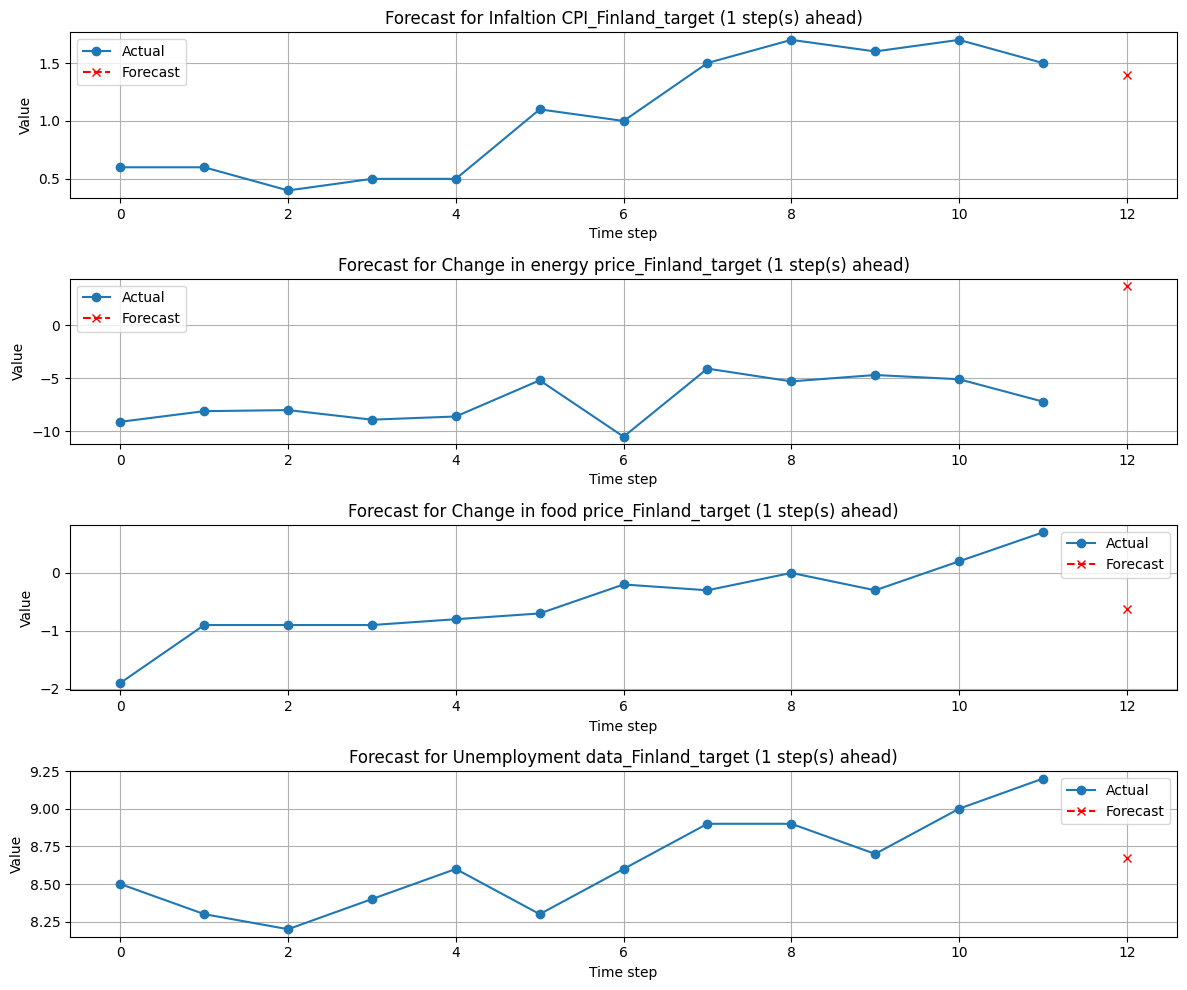

In [ ]:
# Assuming future_forecast_df and y_test are already defined and n_steps is known
num_plots = 4  # number of subplots (columns 0 through 3)

plt.figure(figsize=(12, 10))  # adjust size as needed

for i in range(num_plots):
    target_column = y_test.columns[i]
    
    # Prepare data
    recent_actuals = y_test[target_column].tail(12).reset_index(drop=True)
    forecast_values = pd.Series(future_forecast_df[target_column].values, 
                                index=range(len(recent_actuals), len(recent_actuals) + n_steps))

    # Subplot i+1 (subplot index starts at 1)
    plt.subplot(num_plots, 1, i + 1)
    plt.plot(recent_actuals, label="Actual", marker='o')
    plt.plot(forecast_values, label="Forecast", marker='x', linestyle='--', color='red')
    plt.title(f"Forecast for {target_column} ({n_steps} step(s) ahead)")
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# OLD but gold